## Load and Preprocess Data

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [6]:
BASE_DIR = r"C:\Users\Nived\Downloads\archive"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# DEBUG CHECK (DO THIS ONCE)
print("Train dir exists:", os.path.exists(TRAIN_DIR))
print("Train classes:", os.listdir(TRAIN_DIR))

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Class Mapping:", train_generator.class_indices)

Train dir exists: True
Train classes: ['Benign', 'Malignant']
Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


## Exploratory Data Analysis

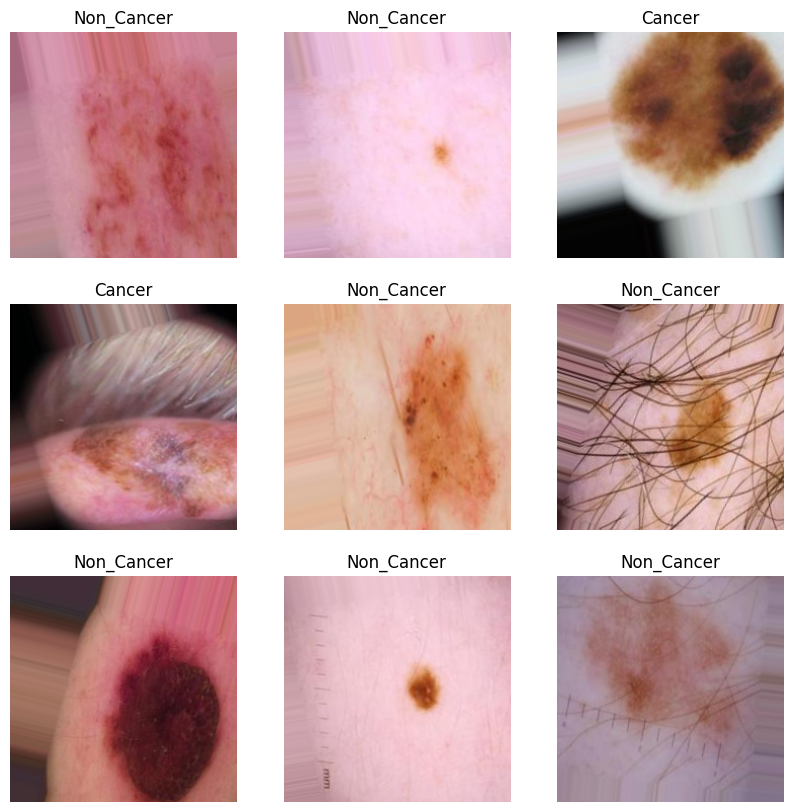

In [7]:
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non_Cancer")
        plt.axis("off")
    plt.show()

plot_images(train_generator)

## Build CNN Model

In [10]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluate Model

In [14]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience =5,
    restore_best_weights = True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30
  372/11879 ━━━━━━━━━━━━━━━━━━━━ 1:52:29 587ms/step - accuracy: 0.7187 - loss: 0.6436

C:\Users\Nived\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11879/11879 ━━━━━━━━━━━━━━━━━━━━ 226s 19ms/step - accuracy: 0.7683 - loss: 0.4957 - val_accuracy: 0.8395 - val_loss: 0.3940 - learning_rate: 0.0010
Epoch 2/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 226s 19ms/step - accuracy: 0.8166 - loss: 0.4072 - val_accuracy: 0.7580 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 3/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 219s 18ms/step - accuracy: 0.8292 - loss: 0.3843 - val_accuracy: 0.8435 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 4/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 253s 21ms/step - accuracy: 0.8399 - loss: 0.3649 - val_accuracy: 0.8255 - val_loss: 0.3937 - learning_rate: 0.0010
Epoch 5/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 298s 25ms/step - accuracy: 0.8338 - loss: 0.3794 - val_accuracy: 0.8710 - val_loss: 0.3257 - learning_rate: 0.0010
Epoch 6/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 323s 25ms/step - accuracy: 0.8468 - loss: 0.3608 - val_accuracy: 0.8665 - val_loss: 0.3291 - learning_rate: 0.0010
Epoch 7/30
11879/11879 ━━━━━━━━━━━━━━━━━━━━ 295s 25ms/ste

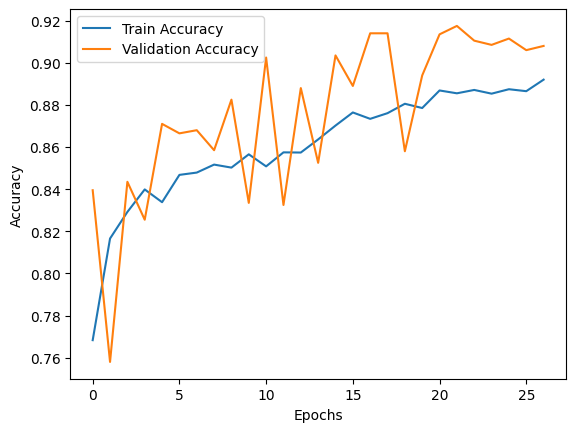

In [15]:
model.save("skin_cancer_cnn.h5")

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate Model Performance

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      1000
           1       0.51      0.50      0.50      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



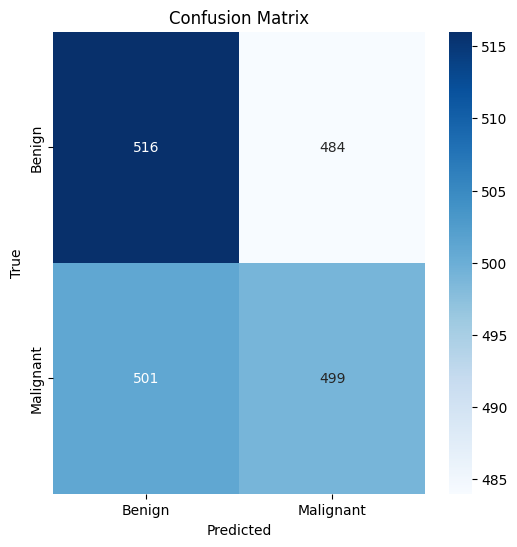

In [16]:
test_pred = model.predict(
    test_generator,
    steps=test_generator.samples,
    verbose=1
)
test_pred_labels = (test_pred>0.5).astype('int32')
test_true_labels=test_generator.classes[:len(test_pred_labels)]
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prediction System

In [17]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/skin_cancer_cnn.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/skin_cancer_cnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)